<a href="https://colab.research.google.com/github/harika140901/ee5333/blob/main/EE5333_tutorials-master/rt/Routing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install mip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.6/462.6 kB 26.7 MB/s eta 0:00:00
  Attempting uninstall: cffi
    Found existing installation: cffi 1.17.1
    Uninstalling cffi-1.17.1:
      Successfully uninstalled cffi-1.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pygit2 1.17.0 requires cffi>=1.17.0, but you have cffi 1.15.1 which is incompatible.


# RSMT using min-cost flow in a network

* $V$ is the set of input vertices to be connected using a RSMT
* $G\equiv (V',E)$ is the Hanan-grid of $V$
* Choose a source vertex $s \in V$ and other vertices in $V \setminus \{s\}$ become the sinks
* $w_{u,v}$ is the cost of edge $(u, v) \in E$
* $y_{u,v}\in\{0,1\}$ is the indicator variable for $(u, v)$ being in the RSMT
* $f_{u,v}^t\in [0,1]$ is the flow variable for edge $(u, v)$, sink $t$

In [4]:
import mip
import math
import networkx as nx

def rsmt(points, lpfile="", draw=False):
  assert len(points) > 1, "works only for 2 or more points"
  X = sorted(list(set([p[0] for p in points])))
  Y = sorted(list(set([p[1] for p in points])))

  G = nx.DiGraph()
  for xi in X:
    for yi in Y:
      G.add_node((xi, yi))

  for i in range(len(X)):
    for j in range(len(Y)):
      if i < len(X) - 1 and j < len(Y) - 1:
        G.add_edge((X[i], Y[j]), (X[i + 1], Y[j]), weight = (X[i + 1] - X[i]))
        G.add_edge((X[i], Y[j]), (X[i], Y[j + 1]), weight = (Y[j + 1] - Y[j]))
        G.add_edge((X[i + 1], Y[j]), (X[i], Y[j]), weight = (X[i + 1] - X[i]))
        G.add_edge((X[i], Y[j + 1]), (X[i], Y[j]), weight = (Y[j + 1] - Y[j]))
      elif i < len(X) - 1:
        G.add_edge((X[i], Y[j]), (X[i + 1], Y[j]), weight = (X[i + 1] - X[i]))
        G.add_edge((X[i + 1], Y[j]), (X[i], Y[j]), weight = (X[i + 1] - X[i]))
      elif j < len(Y) - 1:
        G.add_edge((X[i], Y[j]), (X[i], Y[j + 1]), weight = (Y[j + 1] - Y[j]))
        G.add_edge((X[i], Y[j + 1]), (X[i], Y[j]), weight = (Y[j + 1] - Y[j]))

  model = mip.Model(solver_name='CBC')
  src = points[0]
  tgts = set(points[1:])
  xvars = dict()
  yvars = dict()
  for t in tgts:
    for e in G.edges:
      xvars[(e,t)] = model.add_var(name=f"x_e_{e[0][0]}_{e[0][1]}_{e[1][0]}_{e[1][1]}_t_{t[0]}_{t[1]}", lb=0, ub=1)

# in flow at src = 0 and out flow = 1
  for t in tgts:
    model += (mip.xsum(xvars[(e,t)] for e in G.out_edges(src)) == 1.)
    model += (mip.xsum(xvars[(e,t)] for e in G.in_edges(src)) == 0.)

# in flow at sink = 1 and out flow = 0
  for t in tgts:
    model += (mip.xsum(xvars[(e,t)] for e in G.in_edges(t)) == 1.)
    model += (mip.xsum(xvars[(e,t)] for e in G.out_edges(t)) == 0.)

# y_{u,v} for maximal sharing of edges across paths
  yvars_dict = dict()
  for e in G.edges:
    if e[0][0] < e[1][0] or e[0][1] < e[1][1]:
      for t in tgts:
        if not yvars_dict.get(e): yvars_dict[e] = []
        yvars_dict[e].append(t)
  for e, l in yvars_dict.items():
    yvars[e] = model.add_var(var_type=mip.BINARY, name=f"y_e_{e[0][0]}_{e[0][1]}_{e[1][0]}_{e[1][1]}")
    for t in l:
      model += xvars[(e,t)] + xvars[((e[1], e[0]),t)] <= yvars[e]

# flow conservation for each sink
  for tgt in tgts:
    othVertices = set(G.nodes) - set([tgt]) - set([src])
    for v in othVertices:
      model += mip.xsum(xvars[(e, tgt)] for e in G.in_edges(v)) == mip.xsum(xvars[(e,tgt)] for e in G.out_edges(v))

  model.objective = mip.xsum(G.edges[e]['weight'] * yvars[e] for e in yvars)

  model.write(lpfile if lpfile != "" else "out.lp")
  model.verbose = 0

  model.optimize()
  rsmtLen = 0
  stedges = [e for e in yvars if yvars[e].x >= 0.9]
  outv = set()
  for e in stedges:
    outv.add(e[0])
    outv.add(e[1])
    rsmtLen += G.edges[e]['weight']
  print("RSMT len : ", rsmtLen)

  if draw:
    import matplotlib.pyplot as plt
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={e:G.edges[e]['weight'] for e in G.edges})
    nx.draw_networkx_edges(G, pos, edgelist = stedges, edge_color="r", style="dashed")
    plt.show()

  return (rsmtLen, stedges)


RSMT len :  20


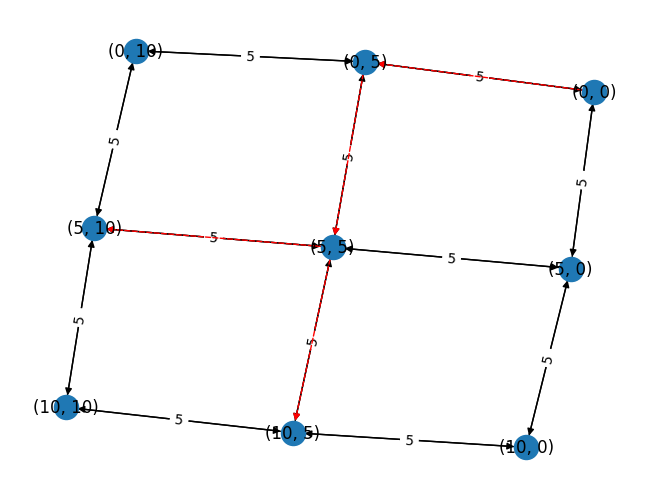

RSMT len :  35


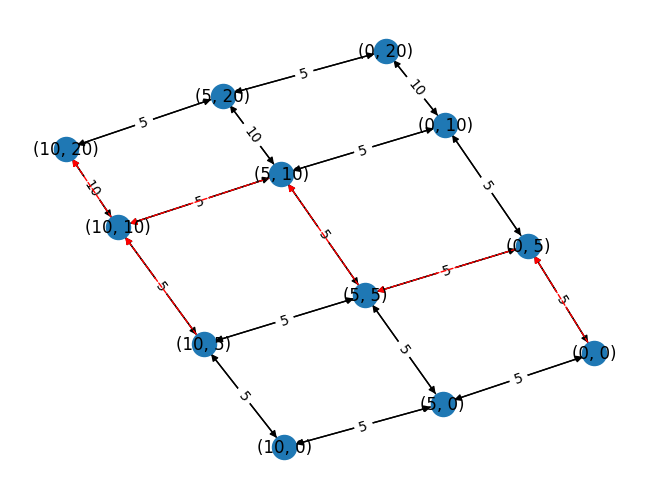

(35,
 [((0, 0), (0, 5)),
  ((0, 5), (5, 5)),
  ((5, 5), (5, 10)),
  ((5, 10), (10, 10)),
  ((10, 5), (10, 10)),
  ((10, 10), (10, 20))])

In [67]:
rsmt([(0,0),(10,5),(5,10)], "", True)
rsmt([(0,0),(10,5),(5,10),(10,20)], "", True)

# Minimum Spanning Tree
## Prim’s algorithm from MST
* Input graph $G \equiv (V, E)$ and each edge $(u, v) \in E$ has a cost $w_{u,v} \in \mathbb{R}^+$
  1. Choose s ∈ V and insert it into visited set: $Visited = \{s\}$
  2. $T = \emptyset$
  3. Repeat as long as $|T| < |V| - 1$
    1. $u \in V \setminus Visited$ is the nearest neighbour of $Visited$
    2. $v$ is the the nearest neighbour of $u$ in $Visited$
    3. Insert $(u, v)\in E$ into $T$
  4. Return $T$

In [74]:
def rmst(points):
  G = nx.Graph()
  for p in points:
    G.add_node(p)
  for i in range(len(points)):
    for j in range(i + 1, len(points)):
      G.add_edge(points[i], points[j], weight = abs(points[i][0] - points[j][0]) + abs(points[i][1] - points[j][1]))
  listofVisitedNodes = []
  otherVertices = []
  listofVisitedNodes.append(points[0])
  for p in points:
    if p not in listofVisitedNodes:
      otherVertices.append(p)

  cost = 0
  while len(otherVertices) != 0:
    x = listofVisitedNodes[-1]
    tempDist = []
    for p in otherVertices:
      if ((x[0],x[1]),(p[0],p[1])) in G.edges:
        tempDist.append((abs(p[0] - x[0]) + abs(p[1] - x[1]), p))
    d = min([x[0] for x in tempDist])
    for (t,p) in tempDist:
      if t == d:
        otherVertices.remove(p)
        listofVisitedNodes.append(p)
        cost += d
        break

  return (cost, listofVisitedNodes)

In [75]:
print(rmst([(0,0),(10,5),(5,10)]))
print(rmst([(0,0),(10,5),(5,10),(10,20)]))

(25, [(0, 0), (10, 5), (5, 10)])
(40, [(0, 0), (10, 5), (5, 10), (10, 20)])


In [76]:
import random
import time
N=5
points = [(random.randint(0,100), random.randint(0,100)) for i in range(N)]
print(points)
for fn in [rsmt, rmst]:
  t = time.time()
  length, sol = fn(points)
  print(fn.__name__, length, time.time()-t)

[(66, 37), (88, 43), (83, 51), (92, 89), (9, 60)]
RSMT len :  152
rsmt 152 1.5985150337219238
rmst 200 0.00010275840759277344


# Shortest path between a pair of vertices
The cost of edge between $(u,v)$ as the Manhattan distance between $u$ and $v$.



## Dijkstra's algorithm
* Input graph $G \equiv (V, E)$ and each edge $(u, v) \in E$ has a cost $w_{u,v} \in \mathbb{R}^+$
* Find shortest path beween vertices $s\in V$ and $t\in V$
  1. $(s.dist, s.parent) := (0, NULL)$
  2. $(v.dist, v.parent) := (\infty, NULL)$, $\forall v \in V \setminus \{s\}$
  3. Priority $Q$; prioritizes on least distance from $s$
  4. Repeat until $Q$ is empty:
    1. $u := Q.pop()$
    2. if $u = t$: break
    3. Repeat for each $(u, v) \in E$ and $v\in Q$:

      if $v.dist > u.dist + w_{u,v}$:
          $(v.dist, v.parent) = (u.dist + w_{u,v}, u)$
  5. $path = [t]$
  6. while $path.last().parent~!=~NULL$:

    $path.append(path.last().parent)$
  7. Return $path$

In [77]:
import math
import networkx as nx
import heapq as hq

# Utility function to calculate Manhattan distance (used in both A* and Dijkstra)
def dist(u, v):
    return abs(u._xy[0] - v._xy[0]) + abs(u._xy[1] - v._xy[1])

# Vertex class for A* and Dijkstra
class Vertex:
    def __init__(self, x, y, cost=math.inf, h=0, parent=None, nbrs=None):
        self._xy = (x, y)
        self._cost = cost
        self._parent = parent
        self._nbrs = nbrs or []  # Avoid default mutable arguments
        self._h = h  # heuristic value for A*
        self._f = self._cost + self._h  # total cost (g + h) for A*

    def __lt__(self, other):
        return self._f < other._f  # for A* prioritize by f = g + h

    def __eq__(self, other):
        return self._xy == other._xy

    def __repr__(self):
        return f'(xy:{self._xy}, cost:{self._cost}, f:{self._f})'

# Priority Queue class for A* and Dijkstra
class PriorityQueue:
    def __init__(self, vertices=[]):
        self._q = vertices[:]
        hq.heapify(self._q)

    def push(self, v):
        hq.heappush(self._q, v)

    def pop(self):
        return hq.heappop(self._q)

    def update(self, v, cost):
        # Update vertex in priority queue
        try:
            i = self._q.index(v)
        except ValueError:
            return
        if i is not None:
            v._cost = cost
            v._f = v._cost + v._h  # recalculate f = g + h for A*
            hq.heapify(self._q)

    def empty(self):
        return len(self._q) == 0

    def __contains__(self, v):
        return v in self._q

    def __repr__(self):
        return str(self._q)

In [78]:
def dijkstra(V, s, t):
    for v in V:
        v._cost, v._parent, v._h = math.inf, None, 0
    s._cost = 0
    Q = PriorityQueue(V)

    while not Q.empty():
        u = Q.pop()
        if u == t:
            break
        for v in u._nbrs:
            if v in Q:
                new_cost = u._cost + dist(u, v)
                if new_cost < v._cost:
                    Q.update(v, new_cost)
                    v._parent = u

    path = []
    while t._parent is not None:
        path.append(t)
        t = t._parent
    path.append(s)
    path.reverse()
    return path

## A* algorithm
* Input graph $G \equiv (V, E)$ and each edge $(u, v) \in E$ has a cost $w_{u,v} \in \mathbb{R}^+$
* Find shortest path beween vertices $s\in V$ and $t\in V$
* dist(u, v) returns an estimate of minimum distance between u and v
  * The estimate has to be a lower bound on the true distance
  1. $(s.g, s.h, s.parent) := (0, dist(s, t), NULL)$
  2. $(v.g, v.h, v.parent) := (\infty, dist(v, t), NULL)$, $\forall v \in V \setminus \{s\}$
  3. Priority $Q = \{s\}$; prioritizes on least $v.g + v.h$
    * If $u, v \in Q$ have $u.g + u.h = v.g + v.h$, $u$ gets higher priority if $u.g > v.g$ and vice-versa
  4. Repeat until $Q$ is empty:
    1. $u := Q.pop()$
    2. if $u = t$: break
    3. Repeat for each $(u, v) \in E$:

      * if $v.g > u.g + w_{u,v}$:
          * $(v.g, v.parent) = (u.g + w_{u,v}, u)$
          * if $v \in Q$: $update(Q)$
          * else:$Q.push(v)$
  5. $path = [t]$
  6. while $path.last().parent~!=~NULL$:

    $path.append(path.last().parent)$
  7. Return $path$

In [79]:
def astar(V, s, t):
    for v in V:
        v._h = dist(v, t)  # Set heuristic for A* (Manhattan distance)

    s._cost = 0  # Start node cost is 0
    Q = PriorityQueue(V)
    alreadyEvaluated = []

    while not Q.empty():
        u = Q.pop()
        if u == t:
            break
        alreadyEvaluated.append(u)
        for v in u._nbrs:
            if v in alreadyEvaluated:
                continue
            gnew = u._cost + dist(u, v)
            if v not in Q:
                Q.push(v)
            if gnew < v._cost:
                Q.update(v, gnew)
                v._parent = u

    path = []
    while t._parent is not None:
        path.append(t)
        t = t._parent
    path.append(s)
    path.reverse()
    return path

In [80]:
Vertices = [Vertex(0, 0, -1), Vertex(0,10,-1), Vertex(5,5,-1), Vertex(5,10,-1), Vertex(10,10,-1)]
Vertices[0]._nbrs = [Vertices[1], Vertices[2]]
Vertices[1]._nbrs = [Vertices[0], Vertices[4]]
Vertices[2]._nbrs = [Vertices[1], Vertices[3]]
Vertices[3]._nbrs = [Vertices[2], Vertices[4]]
Vertices[4]._nbrs = [Vertices[1], Vertices[3]]
for alg in [dijkstra, astar]:
  src = Vertices[0]
  tgt = Vertices[-1]
  print('src :', src, ' tgt :', tgt, 'path :', alg(Vertices, src, tgt))

src : (xy:(0, 0), cost:0, f:-1)  tgt : (xy:(10, 10), cost:inf, f:-1) path : [(xy:(0, 0), cost:0, f:-1)]
src : (xy:(0, 0), cost:0, f:-1)  tgt : (xy:(10, 10), cost:inf, f:-1) path : [(xy:(0, 0), cost:0, f:-1)]


In [45]:
import random
Vertices = [Vertex(random.randint(0,1000), random.randint(0,1000), -1) for i in range(10000)]
for v in Vertices:
  if v._nbrs is None: v._nbrs = list()
  for i in range(random.randint(1, 2)):
    nbr = Vertices[random.randint(0, len(Vertices)-1)]
    if nbr._nbrs is None: nbr._nbrs = list()
    v._nbrs.append(nbr)
    nbr._nbrs.append(v)
for alg in [dijkstra, astar]:
  src = Vertices[0]
  tgt = Vertices[-1]
  import time
  t = time.time()
  path = alg(Vertices, src, tgt)
  print('src :', src, ' tgt :', tgt, 'path :', path, time.time() - t)

src : (xy:(676, 711), cost:0)  tgt : (xy:(798, 67), cost:3798) path : [(xy:(798, 67), cost:3798), (xy:(188, 483), cost:2772), (xy:(421, 732), cost:2290), (xy:(728, 496), cost:1747), (xy:(855, 283), cost:1407), (xy:(864, 448), cost:1233), (xy:(925, 118), cost:842), (xy:(676, 711), cost:0)] 7.909726142883301
src : (xy:(676, 711), cost:0)  tgt : (xy:(798, 67), cost:3798) path : [(xy:(798, 67), cost:inf)] 14.980444431304932


In [ ]:
|